In [1]:

import os
import re
import sys
import random
from pathlib import Path

import requests
import json
import xml.etree.ElementTree as ET
import certifi

import pandas as pd
import numpy as np

import rasterio
import matplotlib.pyplot as plt
import matplotlib.image
from rasterio.windows import Window

In [2]:
url_dataspace = "https://catalogue.dataspace.copernicus.eu/odata/v1"

# Filtering
satellite = "SENTINEL-2"
level = "S2MSI2A"
cloud_cover_max = 0.2

aoi_point ="POINT(-120.9970 37.6393)"
aoi_polygon = "POLYGON ((-121.0616 37.6391, -120.966 37.6391, -120.966 37.6987, -121.0616 37.6987, -121.0616 37.6391))"

start_date = "2023-11-01"
end_date = "2023-11-10"
start_date_full =start_date+"T00:00:00.000Z"
end_date_full = end_date +"T00:00:00.000Z"

In [3]:
query = f"{url_dataspace}/Products?$filter=Collection/Name eq '{satellite}' and Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'productType' and att/OData.CSC.StringAttribute/Value eq '{level}') and OData.CSC.Intersects(area=geography'SRID=4326;{aoi_point}') and ContentDate/Start gt {start_date_full} and ContentDate/Start lt {end_date_full}"
response = requests.get(query).json()
result = pd.DataFrame.from_dict(response["value"])

# Filter records where 'online' column is True
result = result[result['Online'] == True]

# print first 10 results
result.head(10)

,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
0,application/octet-stream,1c7dcc3f-7c0a-4e26-9f2e-dbf19faff10e,S2A_MSIL2A_20231102T184531_N0509_R070_T10SFG_2...,application/octet-stream,514963512,2023-11-03T00:09:45.089000Z,2023-11-03T00:28:25.183279Z,2024-03-14T11:26:56.565785Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L2A/2023/11/02/S2A_MSIL...,"[{'Value': '59a944f68bd6c21bd65956fdeb113124',...","{'Start': '2023-11-02T18:45:31.024000Z', 'End'...",geography'SRID=4326;POLYGON ((-121.26198172100...,"{'type': 'Polygon', 'coordinates': [[[-121.261..."
1,application/octet-stream,8b4c912f-f54d-4b61-bca1-d4cae2e66c07,S2A_MSIL2A_20231105T185551_N0509_R113_T10SFG_2...,application/octet-stream,950862763,2023-11-05T23:15:20.251000Z,2023-11-05T23:32:29.458289Z,2024-03-14T11:39:44.261261Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L2A/2023/11/05/S2A_MSIL...,"[{'Value': '5fba36122824578f253e7385269dcaf0',...","{'Start': '2023-11-05T18:55:51.024000Z', 'End'...",geography'SRID=4326;POLYGON ((-121.86192606806...,"{'type': 'Polygon', 'coordinates': [[[-121.861..."
2,application/octet-stream,821980f4-4d14-4658-8072-e27003f06ea5,S2B_MSIL2A_20231107T184559_N0509_R070_T10SFG_2...,application/octet-stream,538085262,2023-11-07T22:25:05.431000Z,2023-11-07T22:43:57.641514Z,2024-03-14T11:47:46.441371Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L2A/2023/11/07/S2B_MSIL...,"[{'Value': '008c78bb15712ea9da208d0fc28b1056',...","{'Start': '2023-11-07T18:45:59.024000Z', 'End'...",geography'SRID=4326;POLYGON ((-121.27475211534...,"{'type': 'Polygon', 'coordinates': [[[-121.274..."


In [6]:
username = "narashiman.tarun@gmail.com"
password = "}AW?w%djyVQ4SEk"


auth_server_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
data = {
    "client_id": "cdse-public",
    "grant_type": "password",
    "username": username,
    "password": password,
}

response = requests.post(auth_server_url, data=data, verify=True, allow_redirects=False)
access_token = json.loads(response.text)["access_token"]
# Establish session
session = requests.Session()
session.headers["Authorization"] = f"Bearer {access_token}"

product_row_id = 0   # 0 for the first product in the list
product_id = result.iloc[product_row_id, 1]
print(product_id)
product_name = result.iloc[product_row_id, 2]
print(product_name)

url_MTD = f"{url_dataspace}/Products({product_id})/Nodes({product_name})/Nodes(MTD_MSIL2A.xml)/$value"
response = session.get(url_MTD, allow_redirects=False)
while response.status_code in (301, 302, 303, 307):
    url_MTD_location = response.headers["Location"]
    response = session.get(url_MTD_location, allow_redirects=False)

file = session.get(url_MTD_location, verify=False, allow_redirects=True)

# Save the product in home directory
outfile = Path("C:\\Projects\\pythonendsemproject\\SatelliteImageExtractor-master\\content\\MTD_MSIL2A.xml")
outfile.write_bytes(file.content)

1c7dcc3f-7c0a-4e26-9f2e-dbf19faff10e
S2A_MSIL2A_20231102T184531_N0509_R070_T10SFG_20231102T231756.SAFE


c:\Users\ntaru\anaconda3\envs\SatImgExt\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


55083

In [7]:
# Pass the path of the xml document
tree = ET.parse(str(outfile))
# get the parent tag
root = tree.getroot()

# Get the location of individual bands in Sentinel-2 granule
band_path = []
band_path.append(f"{product_name}/{root[0][0][12][0][0][0].text}.jp2".split("/"))
band_path.append(f"{product_name}/{root[0][0][12][0][0][1].text}.jp2".split("/"))
band_path.append(f"{product_name}/{root[0][0][12][0][0][2].text}.jp2".split("/"))
band_path.append(f"{product_name}/{root[0][0][12][0][0][3].text}.jp2".split("/"))

In [8]:
band_path
[['S2A_MSIL2A_20231102T184531_N0509_R070_T10SFG_20231102T231756.SAFE',
  'GRANULE',
  'L2A_T10SFG_A043682_20231102T184854',
  'IMG_DATA',
  'R10m',
  'T10SFG_20231102T184531_B02_10m.jp2'],
 ['S2A_MSIL2A_20231102T184531_N0509_R070_T10SFG_20231102T231756.SAFE',
  'GRANULE',
  'L2A_T10SFG_A043682_20231102T184854',
  'IMG_DATA',
  'R10m',
  'T10SFG_20231102T184531_B03_10m.jp2'],
 ['S2A_MSIL2A_20231102T184531_N0509_R070_T10SFG_20231102T231756.SAFE',
  'GRANULE',
  'L2A_T10SFG_A043682_20231102T184854',
  'IMG_DATA',
  'R10m',
  'T10SFG_20231102T184531_B04_10m.jp2'],
 ['S2A_MSIL2A_20231102T184531_N0509_R070_T10SFG_20231102T231756.SAFE',
  'GRANULE',
  'L2A_T10SFG_A043682_20231102T184854',
  'IMG_DATA',
  'R10m',
  'T10SFG_20231102T184531_B08_10m.jp2']]

[['S2A_MSIL2A_20231102T184531_N0509_R070_T10SFG_20231102T231756.SAFE',
  'GRANULE',
  'L2A_T10SFG_A043682_20231102T184854',
  'IMG_DATA',
  'R10m',
  'T10SFG_20231102T184531_B02_10m.jp2'],
 ['S2A_MSIL2A_20231102T184531_N0509_R070_T10SFG_20231102T231756.SAFE',
  'GRANULE',
  'L2A_T10SFG_A043682_20231102T184854',
  'IMG_DATA',
  'R10m',
  'T10SFG_20231102T184531_B03_10m.jp2'],
 ['S2A_MSIL2A_20231102T184531_N0509_R070_T10SFG_20231102T231756.SAFE',
  'GRANULE',
  'L2A_T10SFG_A043682_20231102T184854',
  'IMG_DATA',
  'R10m',
  'T10SFG_20231102T184531_B04_10m.jp2'],
 ['S2A_MSIL2A_20231102T184531_N0509_R070_T10SFG_20231102T231756.SAFE',
  'GRANULE',
  'L2A_T10SFG_A043682_20231102T184854',
  'IMG_DATA',
  'R10m',
  'T10SFG_20231102T184531_B08_10m.jp2']]

In [10]:
# Build the url
for band_node in band_path:
    url_full = f"{url_dataspace}/Products({product_id})/Nodes({product_name})/Nodes({band_node[1]})/Nodes({band_node[2]})/Nodes({band_node[3]})/Nodes({band_node[4]})/Nodes({band_node[5]})/$value"
    #print(url_full)
    response = session.get(url_full, allow_redirects=False)
    while response.status_code in (301, 302, 303, 307):
        url_full_location = response.headers["Location"]
        response = session.get(url_full_location, allow_redirects=False)
    file = session.get(url_full_location, verify=False, allow_redirects=True)
    # Save the product
    outfile =Path("C:\\Projects\\pythonendsemproject\\SatelliteImageExtractor-master\\content"+band_node[5])
    outfile.write_bytes(file.content)
    print("Saved:", band_node[5])

c:\Users\ntaru\anaconda3\envs\SatImgExt\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T10SFG_20231102T184531_B02_10m.jp2


c:\Users\ntaru\anaconda3\envs\SatImgExt\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T10SFG_20231102T184531_B03_10m.jp2


c:\Users\ntaru\anaconda3\envs\SatImgExt\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T10SFG_20231102T184531_B04_10m.jp2


c:\Users\ntaru\anaconda3\envs\SatImgExt\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T10SFG_20231102T184531_B08_10m.jp2


['contentT10SFG_20231102T184531_B04_10m.jp2', 'contentT10SFG_20231102T184531_B03_10m.jp2', 'contentT10SFG_20231102T184531_B02_10m.jp2']
['red', 'green', 'blue']


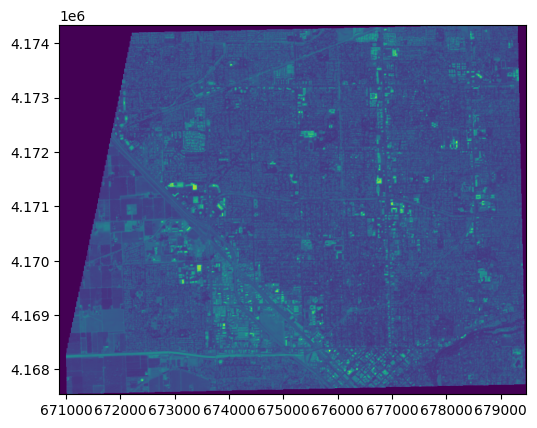

In [13]:
import os
import glob
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.mask import mask
from rasterio.plot import show
from shapely.wkt import loads

# Polygon WKT
aoi_polygon_wkt = "POLYGON ((-121.0616 37.6391, -120.966 37.6391, -120.966 37.6987, -121.0616 37.6987, -121.0616 37.6391))"

# Convert WKT to a GeoPandas DataFrame
aoi_geom = loads(aoi_polygon_wkt)
aoi_gdf = gpd.GeoDataFrame({'geometry': [aoi_geom]})
aoi_gdf.crs = 'EPSG:4326'

# Get a list of input files
input_files = glob.glob('contentT10SFG_*_B0[2-4]_10m.jp2')
input_files=sorted(input_files,reverse=True)
print(input_files)

# Read the CRS from one of the input files
with rasterio.open(input_files[0]) as src:
    input_crs = src.crs

# Convert the AOI polygon to the input CRS
aoi_gdf = aoi_gdf.to_crs(input_crs)

band_mapping = {
    "B02": "blue",
    "B03": "green",
    "B04": "red",
}

# Get the band names for the input files
band_names = [band_mapping[file.split('_')[-2].split('.')[0]] for file in input_files]
print(band_names)
# Clip the images
output_files = []
for i, input_file in enumerate(input_files):
    with rasterio.open(input_file) as src:
        # Clip the image
        out_image, out_transform = mask(src, aoi_gdf.geometry, crop=True)

        # Update the metadata
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})

        # Save the clipped image as a GeoTIFF
        output_file = f"clipped_SR_{i}.tif"
        with rasterio.open(output_file, "w", **out_meta) as dest:
            dest.write(out_image)

        output_files.append(output_file)

# Read the first clipped image
with rasterio.open(output_files[0]) as src:
    stacked_array = src.read()

# Stack the remaining clipped images
for output_file in output_files[1:]:
    with rasterio.open(output_file) as src:
        band_array = src.read()
        stacked_array = np.concatenate((stacked_array, band_array), axis=0)

# Save the stacked array as a GeoTIFF
stacked_meta = out_meta.copy()
stacked_meta.update({"count": len(output_files)})
with rasterio.open("stacked_SR.tif", "w", **stacked_meta) as dest:
    dest.write(stacked_array)
    dest.descriptions = tuple(band_names)

# Plot the stacked image
with rasterio.open("stacked_SR.tif") as src:
    show(src)
